TODO:
* Add weight sharing model
* Add early stopping (saving best model during training)
* Add grid search for hyper parameters
* Make model more sophisticated
* Look and analize where models fail

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

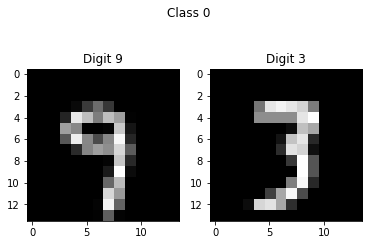

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
input_channels = 2
output_class_channels = 2
output_digit_channels = 10

### Simple model

First let's implement simple model

In [8]:
class NetSimple(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc2 = nn.Linear(50, output_channels)
        
        self.predicts_digit = False

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        output_class = self.forward(x)
        _, predicted_class = torch.max(output_class, 1)
        return predicted_class

In [9]:
net = NetSimple(input_channels, output_class_channels)

In [10]:
def simple_model_criterion(output, target):
    return cross_entropy(output, target)

In [11]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
Total params: 4,346
Trainable params: 4,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Model with weight sharing (Siamese network)

### Model with auxiliary loss

In [12]:
class NetAuxiliaryLoss(nn.Module):
    def __init__(self, input_channels, output_class_channels, output_digit_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 2 * 2, 50)
        self.fc2 = nn.Linear(50, output_class_channels)
        self.fc3 = nn.Linear(50, output_digit_channels)
        self.fc4 = nn.Linear(50, output_digit_channels)
        self.predicts_digit = True

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        output_class = self.fc2(x)
        output_digit1 = self.fc3(x)
        output_digit2 = self.fc4(x)
        return output_class, [output_digit1, output_digit2]
    
    def predict(self, x):
        output_class, output_digits = self.forward(x)
        _, predicted_class = torch.max(output_class, 1)
        _, predicted_digit1 = torch.max(output_digits[0], 1)
        _, predicted_digit2 = torch.max(output_digits[1], 1)
        return predicted_class, [predicted_digit1, predicted_digit2]

In [13]:
net = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

In [14]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 12, 12]             114
         MaxPool2d-2              [-1, 6, 6, 6]               0
            Conv2d-3             [-1, 16, 4, 4]             880
         MaxPool2d-4             [-1, 16, 2, 2]               0
            Linear-5                   [-1, 50]           3,250
            Linear-6                    [-1, 2]             102
            Linear-7                   [-1, 10]             510
            Linear-8                   [-1, 10]             510
Total params: 5,366
Trainable params: 5,366
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [15]:
def auxiliary_loss_criterion(output_class, target_class, output_digits, target_digits):
    return cross_entropy(output_class, target_class) \
            + cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[0], target_digits[:, 1])

## Training

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
def get_accuracy(model, data_loader, calculate_accuracy_digit=False):
    """Calculates accuracy of predicting class or predicting class and digit of model on data from data_loader"""
    if calculate_accuracy_digit:
        return get_accuracy_class_and_digit(model, data_loader)
    else:
        return get_accuracy_class(model, data_loader)
    
def get_accuracy_class(model, data_loader):
    """Calculates accuracy of predicting class of model on data from data_loader"""
    correct_class = 0
    total = 0
    
    for (image, class_target, digit_target) in data_loader:
        predicted_class = model.predict(image)
        correct_class += (predicted_class == class_target).sum().item()
        total += len(class_target)
        
    accuracy = correct_class / total
    return accuracy

def get_accuracy_class_and_digit(model, data_loader):
    """Calculates accuracy of predicting class and digit of model on data from data_loader"""
    correct_class = 0
    correct_digit = 0
    total = 0
    
    for (image, class_target, digit_target) in data_loader:
        predicted_class, (predicted_digit1, predicted_digit2) = model.predict(image)
        correct_class += (predicted_class == class_target).sum().item()
        correct_digit += (predicted_digit1 == digit_target[:, 0]).sum().item()
        correct_digit += (predicted_digit2 == digit_target[:, 1]).sum().item()
        total += len(class_target)
        
    accuracy_class = correct_class / total
    accuracy_digit = correct_digit / total / 2
    return accuracy_class, accuracy_digit

In [18]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion,
          epochs=10, test_every=10):
    """Trains model and computes accuracy on each test_every steps"""
    
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    
    for epoch in range(epochs):
        step = 0
        
        for (image, target_class, target_digits) in train_data_loader:
            step += 1

            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            if step % test_every == 0:
                losses.append(loss)
                
                model.eval()
                with torch.no_grad():
                    accuracy_train_data = get_accuracy(model, train_data_loader,
                                                       calculate_accuracy_digit=model.predicts_digit)
                    accuracy_test_data = get_accuracy(model, test_data_loader,
                                                      calculate_accuracy_digit=model.predicts_digit)
                    
                    if model.predicts_digit: # For model with auxiliary loss
                        acc_train_class, acc_train_digit = accuracy_train_data
                        acc_test_class, acc_test_digit = accuracy_test_data
                        
                        accuracy_train_digit.append(acc_train_digit)
                        accuracy_test_digit.append(acc_test_digit)
                    else:
                        acc_train_class = accuracy_train_data
                        acc_test_class = accuracy_test_data
                        
                    accuracy_train_class.append(acc_train_class)
                    accuracy_test_class.append(acc_test_class)

        print(f"Epoch {epoch + 1}/{epochs}, Step {step}, loss {losses[-1]:0.4f},",
              f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]},",
              f"digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
              if accuracy_train_digit else "")
        
    return accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit, losses

In [19]:
def grid_search():
    """Grid search for tuning hyperparameters"""
    pass

In [20]:
def plot_loss(accuracy_train, accuracy_test, losses, title):
    fig, ax1 = plt.subplots()

    color_tr = 'tab:green'
    color_val = 'tab:blue'
    ax1.set_xlabel("Step (x100)")
    ax1.set_ylabel("Accuracy (train - green, validation - blue)")
    ax1.plot(range(len(accuracy_train)), accuracy_train, color=color_tr)
    ax1.plot(range(len(accuracy_test)), accuracy_test, color=color_val)
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color_loss = 'tab:red'
    ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
    ax2.plot(range(len(losses)), losses, color=color_loss)
    ax2.tick_params(axis='y', labelcolor=color_loss)

    fig.tight_layout()
    plt.title(title)
    plt.grid()
    plt.show()

In [21]:
def test_samples(model, nb_tests=5):
    indices_to_test = (torch.rand(nb_tests) * len(test_input)).int()

    for ind in indices_to_test:
        image = test_input[ind]
        target_class = test_class[ind]
        target_digit = test_digit[ind]

        if model.predicts_digit:
            predicted_class, predicted_digits = model.predict(image.unsqueeze(0))
        else:
            predicted_class = model.predict(image.unsqueeze(0))

        fig, axs = plt.subplots(1, 2)
        for i in range(2):
            axs[i].imshow(image[i], cmap="gray")
            title = f"Digit: {target_digit[i].item()}" + \
            (f", predicted: {predicted_digits[i].item()}" if model.predicts_digit else "")
            axs[i].set_title(title)
        
        fig.suptitle(f"Class: {target_class.item()}, predicted: {predicted_class.item()}")

        plt.show()

#### Simple net

In [22]:
reg = 0.8
lr = 0.005 # TODO Add learning rate decay
epochs = 40
net_simple = NetSimple(input_channels, output_class_channels)

train_info = train(train_loader, test_loader,
             model=net_simple,
             optimizer=optim.Adam(net_simple.parameters(), lr=lr, weight_decay=reg), 
             criterion=simple_model_criterion,
             epochs=epochs, test_every=2)
accuracy_train_class, accuracy_test_class, _, _, losses = train_info

Epoch 1/40, Step 16, loss 0.6128, class train/test accuracy: 0.691/0.697, 
Epoch 2/40, Step 16, loss 0.5924, class train/test accuracy: 0.719/0.718, 
Epoch 3/40, Step 16, loss 0.5845, class train/test accuracy: 0.716/0.726, 
Epoch 4/40, Step 16, loss 0.5622, class train/test accuracy: 0.736/0.741, 
Epoch 5/40, Step 16, loss 0.5499, class train/test accuracy: 0.743/0.751, 
Epoch 6/40, Step 16, loss 0.5284, class train/test accuracy: 0.744/0.741, 
Epoch 7/40, Step 16, loss 0.5101, class train/test accuracy: 0.754/0.749, 
Epoch 8/40, Step 16, loss 0.5061, class train/test accuracy: 0.761/0.752, 
Epoch 9/40, Step 16, loss 0.5052, class train/test accuracy: 0.761/0.761, 
Epoch 10/40, Step 16, loss 0.5003, class train/test accuracy: 0.762/0.768, 
Epoch 11/40, Step 16, loss 0.4970, class train/test accuracy: 0.763/0.765, 
Epoch 12/40, Step 16, loss 0.4944, class train/test accuracy: 0.766/0.765, 
Epoch 13/40, Step 16, loss 0.4876, class train/test accuracy: 0.768/0.768, 
Epoch 14/40, Step 16,

In [23]:
net_simple_filename = "net_simple.ckpt"
torch.save(net_simple.state_dict(), net_simple_filename)

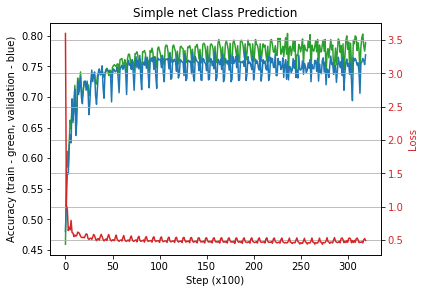

In [24]:
plot_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

#### Auxiliary loss

In [25]:
reg = 0.8
lr = 0.001 # TODO Add learning rate decay
epochs = 40
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)

train_info = train(train_loader, test_loader,
                    model=net_auxiliary_loss,
                    optimizer=optim.Adam(net_auxiliary_loss.parameters(), lr=lr, weight_decay=reg), 
                    criterion=auxiliary_loss_criterion,
                    epochs=epochs, test_every=2)
accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit, losses = train_info

Epoch 1/40, Step 16, loss 8.1282, class train/test accuracy: 0.52/0.529, digit train/test accuracy: 0.1265/0.123
Epoch 2/40, Step 16, loss 5.9394, class train/test accuracy: 0.553/0.567, digit train/test accuracy: 0.1655/0.143
Epoch 3/40, Step 16, loss 5.3684, class train/test accuracy: 0.577/0.59, digit train/test accuracy: 0.1675/0.1525
Epoch 4/40, Step 16, loss 4.9471, class train/test accuracy: 0.606/0.603, digit train/test accuracy: 0.1925/0.1735
Epoch 5/40, Step 16, loss 4.7466, class train/test accuracy: 0.631/0.625, digit train/test accuracy: 0.205/0.1855
Epoch 6/40, Step 16, loss 4.5571, class train/test accuracy: 0.658/0.641, digit train/test accuracy: 0.224/0.2005
Epoch 7/40, Step 16, loss 4.4213, class train/test accuracy: 0.676/0.658, digit train/test accuracy: 0.2395/0.207
Epoch 8/40, Step 16, loss 4.3171, class train/test accuracy: 0.707/0.678, digit train/test accuracy: 0.2455/0.217
Epoch 9/40, Step 16, loss 4.2360, class train/test accuracy: 0.728/0.687, digit train/te

In [26]:
net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

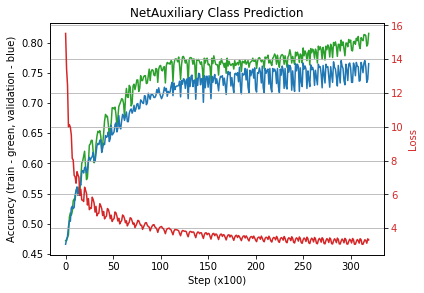

In [27]:
plot_loss(accuracy_train_class, accuracy_test_class, losses, title="NetAuxiliary Class Prediction")

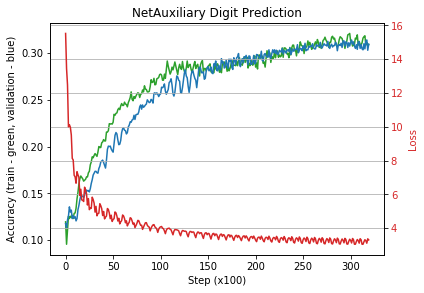

In [28]:
plot_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetAuxiliary Digit Prediction")

### Test

#### Simple net

In [29]:
checkpoint = torch.load(net_simple_filename)
net_simple = NetSimple(input_channels, output_class_channels)
net_simple.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

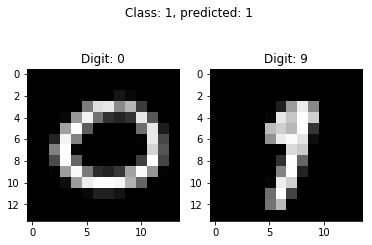

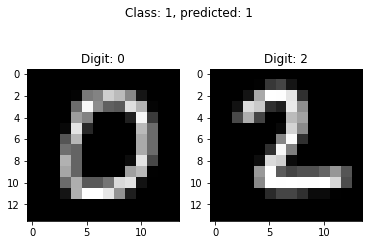

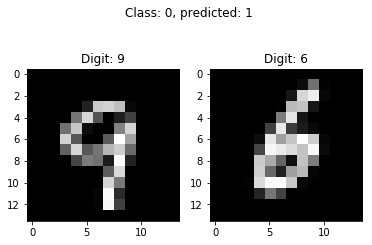

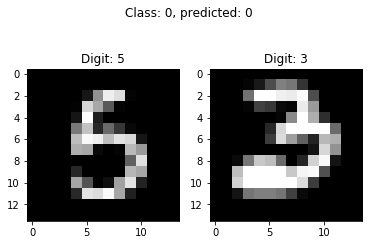

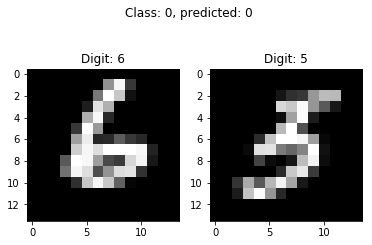

In [30]:
test_samples(net_simple)

#### Weight sharing (Siamese network)

#### Auxiliary loss

In [31]:
checkpoint = torch.load(net_auxiliary_loss_filename)
net_auxiliary_loss = NetAuxiliaryLoss(input_channels, output_class_channels, output_digit_channels)
net_auxiliary_loss.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

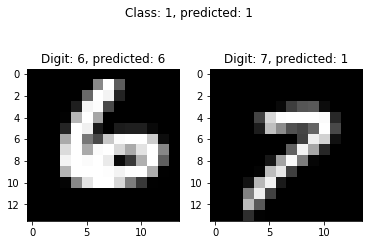

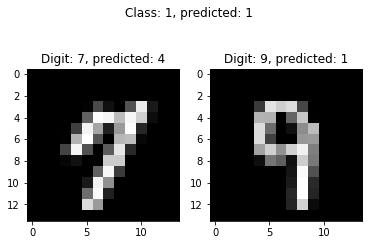

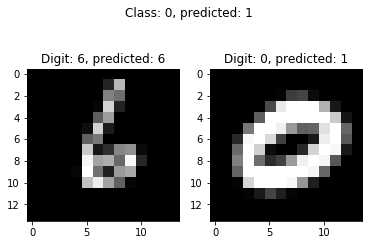

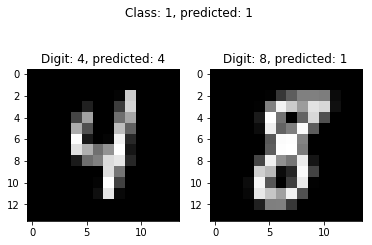

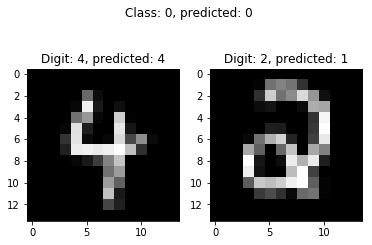

In [32]:
test_samples(net_auxiliary_loss)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.